## Experiment 11: Image t-SNE
Adapted from https://nextjournal.com/ml4a/image-t-sne

Import modules

In [1]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

In [2]:
images, pca_features, pca = pickle.load(open('features_posts.p', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: Datasets/ingr/images/10159636104980962.jpg, features: -3.68,9.63,-15.86,-0.96... 
image: Datasets/ingr/images/10159636289825962.jpg, features: -9.69,-15.59,16.11,7.38... 
image: Datasets/ingr/images/10159635983895962.jpg, features: -19.34,-3.35,4.28,1.27... 
image: Datasets/ingr/images/10159635136250962.jpg, features: -11.44,10.00,1.33,0.95... 
image: Datasets/ingr/images/10159635038980962.jpg, features: -13.94,-9.00,-19.19,0.74... 


In [3]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [4]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.005s...
[t-SNE] Computed neighbors for 1000 samples in 0.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 20.363294
[t-SNE] Computed conditional probabilities in 0.043s
[t-SNE] Iteration 50: error = 76.6314850, gradient norm = 0.2709083 (50 iterations in 0.619s)
[t-SNE] Iteration 100: error = 77.3052063, gradient norm = 0.2623806 (50 iterations in 0.603s)
[t-SNE] Iteration 150: error = 77.1876907, gradient norm = 0.2775419 (50 iterations in 0.601s)
[t-SNE] Iteration 200: error = 76.5033188, gradient norm = 0.3113987 (50 iterations in 0.721s)
[t-SNE] Iteration 250: error = 77.2024994, gradient norm = 0.2755404 (50 iterations in 0.606s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.202499
[t-SNE] Iteration 300: error = 1.5924237, gradient norm = 0.0021644 (50 iterations in 0.464s)
[t-SNE] Iteration 350: error = 1.4791994, gradient norm = 0.0006

In [5]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

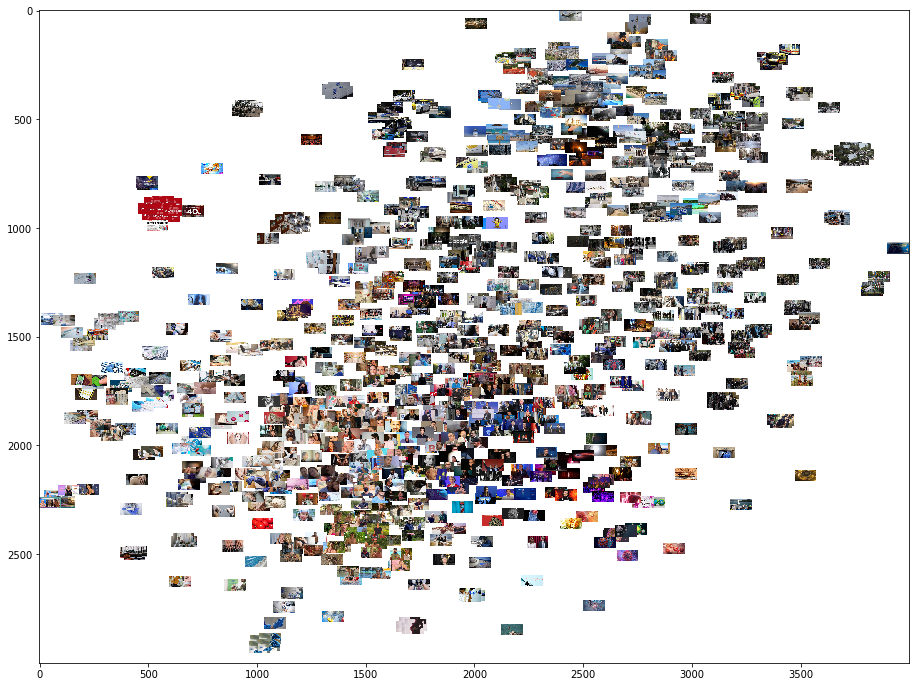

In [6]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [7]:
full_image.save("example-tSNE-posts.png")

In [8]:
tsne_path = "example-tSNE-points-posts.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to example-tSNE-points-posts.json


In [11]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

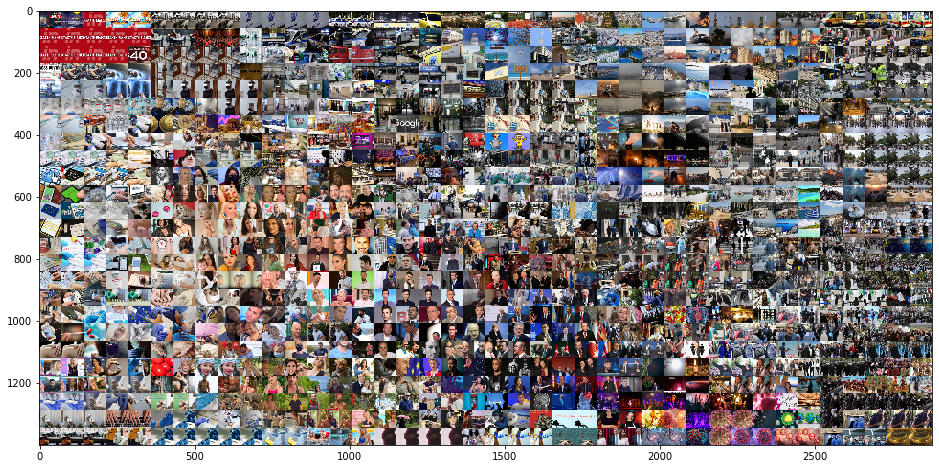

In [12]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [13]:
grid_image.save("example-tSNE-grid-posts.jpg")